In [25]:
"""
Mini Project: Customer Income Normalization (End-to-End)

Goal:
Normalize `annual_income` so it becomes safe + useful for ML models.

We will demonstrate:
1) Diagnose income (missing, zero-coded missing, skew, outliers)
2) Baseline model (NO income normalization) vs Normalized income model
3) Visual validation (before/after hist + boxplot)
4) Model validation (Test MAE/R² + generalization gap)

Dataset: retail_sales_week4.csv
Target: target_sales
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score


In [26]:
# -----------------------------
# 1) Load dataset
# -----------------------------
df = pd.read_csv("D:/datasets/dpp/retail_sales_week4.csv")

TARGET = "target_sales"
ID_COLS = ["customer_id", "store_id"]


In [27]:
# -----------------------------
# 2) Basic validity cleaning (business-rule cleaning, safe before split)
# -----------------------------
df_clean = df.copy()

# Income: 0 or negative => treat as missing
df_clean.loc[df_clean["annual_income"] <= 0, "annual_income"] = np.nan

# Marketing spend negative => missing (not core of this mini project, but avoids noise)
if "marketing_spend" in df_clean.columns:
    df_clean.loc[df_clean["marketing_spend"] < 0, "marketing_spend"] = np.nan


In [28]:
# -----------------------------
# 3) Define features
# -----------------------------
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [c for c in numeric_cols if c not in ID_COLS + [TARGET]]

X = df_clean[numeric_features]
y = df_clean[TARGET]



In [29]:
# -----------------------------
# 4) Train/Test Split (avoid leakage)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [30]:
# -----------------------------
# 5) Diagnostics for annual_income (Train only)
# -----------------------------
income_train = X_train["annual_income"].copy()

print("\n--- INCOME DIAGNOSTICS (TRAIN) ---")
print("Missing %:", round(income_train.isna().mean() * 100, 2))
print("Skewness :", round(income_train.dropna().skew(), 3))
print("Mean     :", round(income_train.dropna().mean(), 2))
print("Median   :", round(income_train.dropna().median(), 2))



--- INCOME DIAGNOSTICS (TRAIN) ---
Missing %: 6.12
Skewness : 8.755
Mean     : 805713.26
Median   : 612665.3


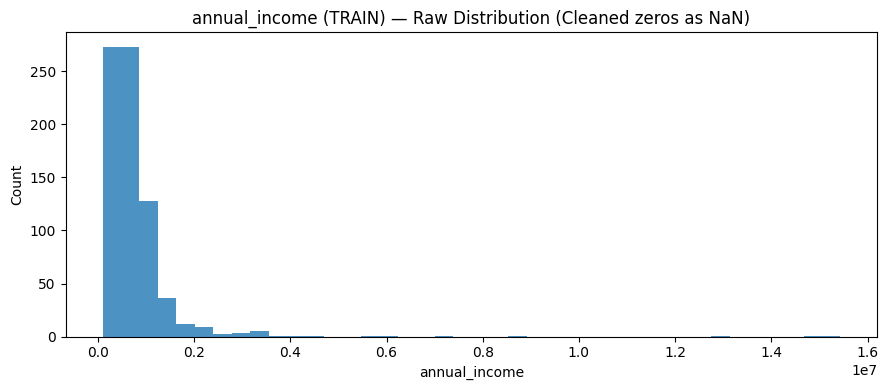

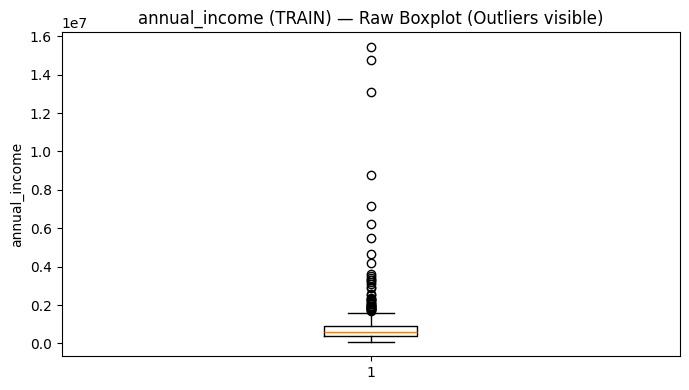

In [31]:
# Visualize RAW income distribution (train)
plt.figure(figsize=(9, 4))
plt.hist(income_train.dropna(), bins=40, alpha=0.8)
plt.title("annual_income (TRAIN) — Raw Distribution (Cleaned zeros as NaN)")
plt.xlabel("annual_income")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.boxplot(income_train.dropna(), showfliers=True)
plt.title("annual_income (TRAIN) — Raw Boxplot (Outliers visible)")
plt.ylabel("annual_income")
plt.tight_layout()
plt.show()


In [32]:
# -----------------------------
# 6) Build TWO approaches:
#    A) Baseline: Standard preprocessing for all numeric columns (impute + scale)
#    B) Income-normalized: Apply special transform to annual_income only
# -----------------------------

# ---- A) Baseline pipeline (no special income normalization)
baseline_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

baseline_model = Pipeline(steps=[
    ("preprocess", baseline_preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

# ---- B) Income normalization pipeline
# Option 1: LOG1P (classic for positive heavy skew)
log1p_transform = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

income_pipeline_log = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log1p", log1p_transform),
    ("scaler", StandardScaler())
])

# Option 2: PowerTransform (Yeo-Johnson) (often better for complex skew)
income_pipeline_power = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("scaler", StandardScaler())
])

# For "other numeric features", we do a simple robust numeric preprocessing
others_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Column groups
income_col = ["annual_income"]
other_cols = [c for c in numeric_features if c != "annual_income"]

# ColumnTransformer versions
preprocess_income_log = ColumnTransformer(
    transformers=[
        ("income", income_pipeline_log, income_col),
        ("others", others_pipeline, other_cols),
    ],
    remainder="drop"
)

preprocess_income_power = ColumnTransformer(
    transformers=[
        ("income", income_pipeline_power, income_col),
        ("others", others_pipeline, other_cols),
    ],
    remainder="drop"
)

model_income_log = Pipeline(steps=[
    ("preprocess", preprocess_income_log),
    ("model", Ridge(alpha=1.0, random_state=42))
])

model_income_power = Pipeline(steps=[
    ("preprocess", preprocess_income_power),
    ("model", Ridge(alpha=1.0, random_state=42))
])



In [33]:
# -----------------------------
# 7) Train + Evaluate helper
# -----------------------------
def evaluate(pipe, name: str):
    pipe.fit(X_train, y_train)
    pred_tr = pipe.predict(X_train)
    pred_te = pipe.predict(X_test)

    mae_tr = mean_absolute_error(y_train, pred_tr)
    mae_te = mean_absolute_error(y_test, pred_te)

    r2_tr = r2_score(y_train, pred_tr)
    r2_te = r2_score(y_test, pred_te)

    print(f"\n=== {name} ===")
    print(f"Train MAE: {mae_tr:,.2f} | Test MAE: {mae_te:,.2f} | Gap(Test-Train): {mae_te - mae_tr:,.2f}")
    print(f"Train R² : {r2_tr:,.4f} | Test R² : {r2_te:,.4f} | Gap(Train-Test): {r2_tr - r2_te:,.4f}")
    return pipe



=== Baseline (All Numeric: Impute + Scale) ===
Train MAE: 2,204.83 | Test MAE: 2,061.45 | Gap(Test-Train): -143.38
Train R² : 0.9748 | Test R² : 0.9908 | Gap(Train-Test): -0.0160

=== Income Normalized (Log1p on annual_income) ===
Train MAE: 2,227.75 | Test MAE: 2,121.94 | Gap(Test-Train): -105.80
Train R² : 0.9748 | Test R² : 0.9892 | Gap(Train-Test): -0.0144

=== Income Normalized (Power YJ on annual_income) ===
Train MAE: 2,228.29 | Test MAE: 2,125.49 | Gap(Test-Train): -102.81
Train R² : 0.9748 | Test R² : 0.9892 | Gap(Train-Test): -0.0144


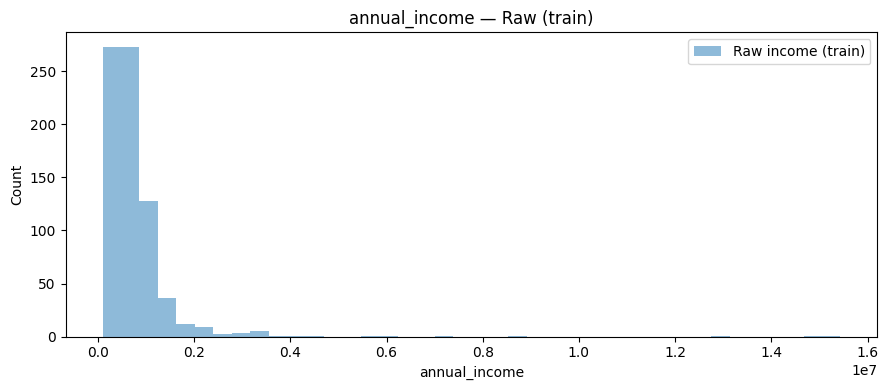

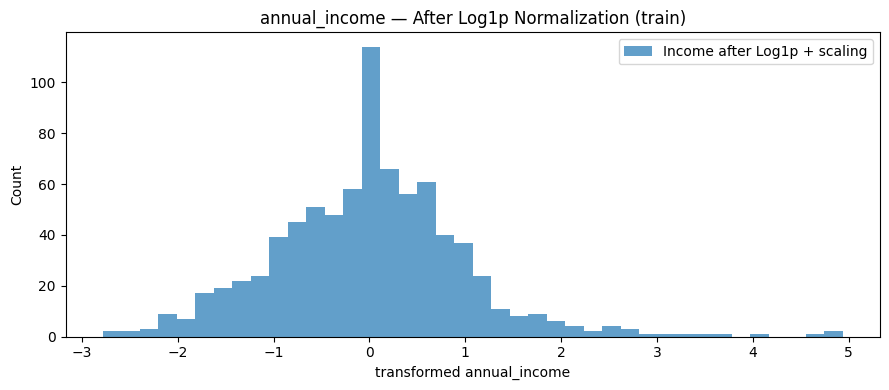

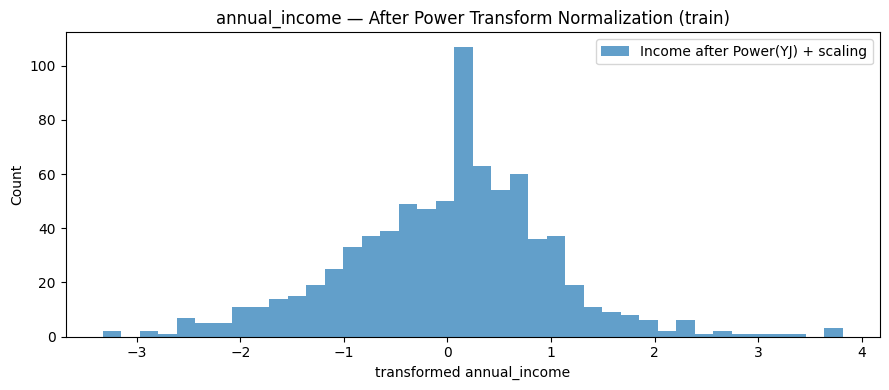

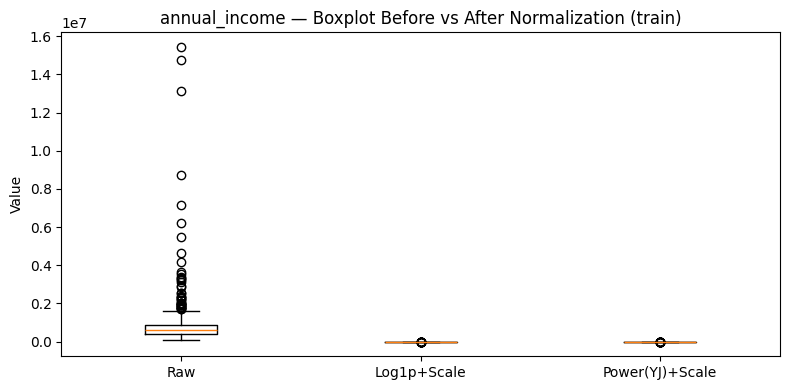

In [34]:
# -----------------------------
# 8) Run experiments
# -----------------------------
baseline_model = evaluate(baseline_model, "Baseline (All Numeric: Impute + Scale)")
model_income_log = evaluate(model_income_log, "Income Normalized (Log1p on annual_income)")
model_income_power = evaluate(model_income_power, "Income Normalized (Power YJ on annual_income)")

# -----------------------------
# 9) Visualize income AFTER normalization (train)
#    We'll extract the transformed income feature values from the fitted preprocessors.
# -----------------------------
# Helper to pull transformed income column from ColumnTransformer output
def get_transformed_income(preprocessor: ColumnTransformer, X_in: pd.DataFrame):
    # Transform full matrix
    X_t = preprocessor.transform(X_in)
    # Income pipeline is first transformer and income has 1 column => it's column 0
    return X_t[:, 0]

# Fit preprocessors alone for visual validation
preprocess_income_log.fit(X_train, y_train)
preprocess_income_power.fit(X_train, y_train)

income_log_vals = get_transformed_income(preprocess_income_log, X_train)
income_pow_vals = get_transformed_income(preprocess_income_power, X_train)

# Hist comparisons
plt.figure(figsize=(9, 4))
plt.hist(income_train.dropna(), bins=40, alpha=0.5, label="Raw income (train)")
plt.title("annual_income — Raw (train)")
plt.xlabel("annual_income")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
plt.hist(income_log_vals, bins=40, alpha=0.7, label="Income after Log1p + scaling")
plt.title("annual_income — After Log1p Normalization (train)")
plt.xlabel("transformed annual_income")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
plt.hist(income_pow_vals, bins=40, alpha=0.7, label="Income after Power(YJ) + scaling")
plt.title("annual_income — After Power Transform Normalization (train)")
plt.xlabel("transformed annual_income")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot comparisons
plt.figure(figsize=(8, 4))
plt.boxplot(
    [income_train.dropna().values, income_log_vals, income_pow_vals],
    tick_labels=["Raw", "Log1p+Scale", "Power(YJ)+Scale"],
    showfliers=True
)
plt.title("annual_income — Boxplot Before vs After Normalization (train)")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


In [35]:
# -----------------------------
# 10) Final takeaway print
# -----------------------------
print("\nMini Project Done.")
print("Next: You can pick the best approach (Log1p or Power) based on:")
print("- Better test metrics (MAE/R²)")
print("- Smaller generalization gap")
print("- More balanced distribution visually")



Mini Project Done.
Next: You can pick the best approach (Log1p or Power) based on:
- Better test metrics (MAE/R²)
- Smaller generalization gap
- More balanced distribution visually
